# Mineração de dados

Nesse trabalho estamos retirando informações dos dados da base de dados **Census Income**.

Como metodologia, estamos aplicando o processo de **KDD (Knowledge Discovery in Databases)**, onde teremos as seguintes etapas:

- **Seleção dos dados**:  
  Escolha dos atributos relevantes da base Census Income para o problema proposto.

- **Pré-processamento**:  
  Tratamento dos dados, incluindo:
  - Conversão de variáveis categóricas em formato numérico.
  - Normalização de variáveis numéricas.

- **Transformação dos dados (Feature Engineering)**:  
  Criação de novas variáveis para enriquecer o conjunto de dados, como:
  - Criação de faixas etárias a partir da variável `age`.
  - Tempo Livre(`free_time`).
  - Proporção de anos estudados(`education_age_ratio`).
  - Cálculo de `capital_net` (`capital-gain` - `capital-loss`).
  - Simplificação do estado civil (`is_married`).

- **Mineração de dados**:  
  Aplicação de algoritmos de Machine Learning para identificar padrões e realizar a tarefa de classificação da renda (`<=50K` ou `>50K`).

- **Interpretação/Evaluação dos resultados**:  
  Análise dos resultados obtidos pelos modelos, avaliando métricas como: 
  - acurácia.
  - precisão.
  - recall.
  - F1-score.

---

**Autores**: Pedro Bianchini de Quadros e Lucas Fernando Assunção Cavalherie  
**Fonte**: [Census Income Dataset - UCI](https://archive.ics.uci.edu/dataset/20/census+income)

## Importando Bibliotecas Necessarias para analise dos dados

In [1]:
%pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

## Importando Banco de Dados

In [3]:
adult = fetch_ucirepo(id=2)

In [4]:
# data (as pandas dataframes)
df = adult.data.features.copy()
df['income'] = adult.data.targets


print(df.shape)

(48842, 15)


In [5]:
# metadata
adult.metadata

{'uci_id': 2,
 'name': 'Adult',
 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult',
 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv',
 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ',
 'area': 'Social Science',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 48842,
 'num_features': 14,
 'feature_types': ['Categorical', 'Integer'],
 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'],
 'target_col': ['income'],
 'index_col': None,
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 1996,
 'last_updated': 'Tue Sep 24 2024',
 'dataset_doi': '10.24432/C5XW20',
 'creators': ['Barry Becker', 'Ronny Kohavi'],
 'intro_paper': None,
 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was ex

In [6]:
# variable information
adult.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


## Pre-Processamento dos dados

In [7]:
def verificar_nulos(df):
    """
    Verifica se existem valores nulos em um DataFrame ou Series do pandas.

    Args:
        df (pd.DataFrame ou pd.Series): Objeto pandas a ser verificado.

    Returns:
        True se houver nulos, False caso contrário.
    """
    if not isinstance(df, (pd.DataFrame, pd.Series)):
        raise TypeError("O objeto precisa ser um pandas DataFrame ou Series.")
    return df.isnull().values.any()

def percentual_nulos(df):
    """
    Mostra o percentual de valores nulos por coluna de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser analisado.

    Returns:
        pd.Series: Série com o percentual de nulos por coluna.
    """
    return (df.isnull().mean() * 100).sort_values(ascending=False)

In [8]:
verificar_nulos(df)

np.True_

In [9]:
percentual_nulos(df)

occupation        1.977806
workclass         1.971664
native-country    0.560993
fnlwgt            0.000000
education         0.000000
education-num     0.000000
age               0.000000
marital-status    0.000000
relationship      0.000000
sex               0.000000
race              0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
income            0.000000
dtype: float64

In [10]:
# Remove linhas com valores nulos
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

percentual_nulos(df)

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital-loss      0.0
hours-per-week    0.0
native-country    0.0
income            0.0
dtype: float64

## Transformação dos dados

### Feature Engineering

Criação da faixa etária

| Faixa | Idade | 
|---------|-------|
| Jovem |(18–25)|
| Adulto |(26–45)|
| Meia-idade |(46–65)|
| Idoso|(66+)|

In [11]:
df['age_group'] = pd.cut(df['age'], bins=[0,25,45,65,100], labels=['Young','Adult','Middle-Aged','Senior'])

"Capital líquido"

In [12]:
df['capital_net'] = df['capital-gain'] - df['capital-loss']

Proporção de anos estudados por idade

In [13]:
df['education_age_ratio'] = df['education-num'] / df['age']

Tempo livre

É calculado usando as horas trabalhadas na semana, menos as 168 horas totais da semana

$$
24 \times 7 = 168 - horas \space trabalhadas

$$

In [14]:
df['free_time'] = 168 - df['hours-per-week']

Casado ou não

In [15]:
df['is_married'] = df['marital-status'].apply(lambda x: 1 if x == 'Married-civ-spouse' else 0)

Obs: Posso combinar mais features, ver dedpois com o Lucas

### Encoding de Features

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

# Colunas categóricas por tipo de codificação
one_hot_cols = ["workclass", "marital-status", "relationship", "race", "sex", "age_group"]
ordinal_col = ["education"]
target_enc_cols = ["occupation", "native-country"]

# Colunas numéricas (incluindo as derivadas)
numeric_cols = [
    "age", "fnlwgt", "education-num", "capital-gain", "capital-loss",
    "hours-per-week", "capital_net", "education_age_ratio", "free_time", "is_married"
]

# Ordem correta para encoding ordinal da escolaridade
education_order = [
    'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th',
    '10th', '11th', '12th', 'HS-grad', 'Some-college',
    'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters',
    'Prof-school', 'Doctorate'
]

# Encoders
one_hot_enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ordinal_enc = OrdinalEncoder(categories=[education_order])
target_enc = TargetEncoder()

# ColumnTransformer
encoder = ColumnTransformer(transformers=[
    ('onehot', one_hot_enc, one_hot_cols),
    ('ordinal', ordinal_enc, ordinal_col),
    ('target', target_enc, target_enc_cols),
    ('numeric', 'passthrough', numeric_cols)
])

In [17]:
X = df.drop(columns='income')
y = df['income']

X_encoded = encoder.fit_transform(X, y)
X_encoded

array([[  0.        ,   0.        ,   0.        , ...,   0.33333333,
        128.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.26      ,
        155.        ,   1.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.23684211,
        128.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.34210526,
        118.        ,   1.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.29545455,
        128.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.37142857,
        108.        ,   1.        ]], shape=(47621, 46))

In [18]:
# 1. Pegue os nomes das colunas do OneHotEncoder
onehot_feature_names = encoder.named_transformers_['onehot'].get_feature_names_out(one_hot_cols)

# 2. Junte os nomes de todas as colunas, na mesma ordem que foram passadas no ColumnTransformer
all_feature_names = list(onehot_feature_names) + ordinal_col + target_enc_cols + numeric_cols

# 3. Crie o DataFrame com os dados transformados e os nomes
df_final = pd.DataFrame(X_encoded, columns=all_feature_names)
df_final['income'] = y.values

### Algoritmos de Scaling

In [19]:
# TODO: Ver com o Lucas, se é necessário

### Resultados Transformações

In [20]:
df_final

,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital-status_Divorced,...,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,capital_net,education_age_ratio,free_time,is_married,income
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,77516.0,13.0,2174.0,0.0,40.0,2174.0,0.333333,128.0,0.0,<=50K
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,83311.0,13.0,0.0,0.0,13.0,0.0,0.260000,155.0,1.0,<=50K
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,215646.0,9.0,0.0,0.0,40.0,0.0,0.236842,128.0,0.0,<=50K
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,234721.0,7.0,0.0,0.0,40.0,0.0,0.132075,128.0,1.0,<=50K
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,338409.0,13.0,0.0,0.0,40.0,0.0,0.464286,128.0,1.0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47616,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,245211.0,13.0,0.0,0.0,40.0,0.0,0.393939,128.0,0.0,<=50K.
47617,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,215419.0,13.0,0.0,0.0,36.0,0.0,0.333333,132.0,0.0,<=50K.
47618,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,374983.0,13.0,0.0,0.0,50.0,0.0,0.342105,118.0,1.0,<=50K.
47619,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,83891.0,13.0,5455.0,0.0,40.0,5455.0,0.295455,128.0,0.0,<=50K.


## Machine Learning

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_squared_error, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Separando X e y
X = df_final.drop(columns=['income'])
y = df_final['income']

# Separar para classificação e regressão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Classificação

In [23]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("🔷 Random Forest - Classificação")
print(classification_report(y_test, y_pred))


🔷 Random Forest - Classificação
              precision    recall  f1-score   support

       <=50K       0.61      0.82      0.70      4924
      <=50K.       0.30      0.13      0.18      2246
        >50K       0.51      0.52      0.52      1617
       >50K.       0.20      0.08      0.12       738

    accuracy                           0.55      9525
   macro avg       0.41      0.39      0.38      9525
weighted avg       0.49      0.55      0.50      9525



### Regressão

In [24]:
# from sklearn.linear_model import LinearRegression

# # Converter alvo para binário
# y_num = y.map({'<=50K': 0, '>50K': 1})
# X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_num, test_size=0.2, random_state=42)

# X_train_r_scaled = scaler.fit_transform(X_train_r)
# X_test_r_scaled = scaler.transform(X_test_r)

# reg = LinearRegression()
# reg.fit(X_train_r_scaled, y_train_r)
# y_pred_r = reg.predict(X_test_r_scaled)

# print("🔶 Linear Regression - Regressão")
# print("MSE:", mean_squared_error(y_test_r, y_pred_r))


### Clusterização

🟣 KMeans - Clusterização
Silhouette Score: 0.5821522132938991


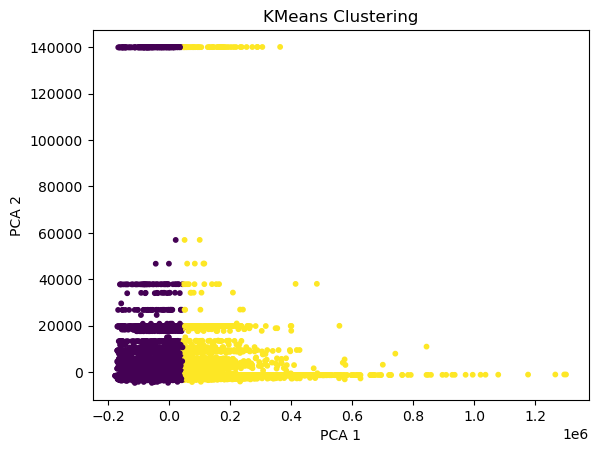

In [25]:
from sklearn.cluster import KMeans

# PCA para visualização
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

# Avaliação
score = silhouette_score(X, labels)
print("🟣 KMeans - Clusterização")
print("Silhouette Score:", score)

# Visualização
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10)
plt.title("KMeans Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


### Compilado dos Algoritmos

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_squared_error, silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

def rodar_pipeline_modelos(df_final):
    resultados = []

    # Separar variáveis
    X = df_final.drop(columns=['income'])
    y_class = df_final['income']
    # y_reg = y_class.map({'<=50K': 0, '>50K': 1})

    # Dividir em treino/teste
    X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
    # _, _, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

    # Escalar os dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_scaled = scaler.fit_transform(X)

    ### CLASSIFICAÇÃO ###
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_scaled, y_train_class)
    y_pred_class = clf.predict(X_test_scaled)
    report = classification_report(y_test_class, y_pred_class, output_dict=True)
    resultados.append({
        'Tipo': 'Classificação',
        'Algoritmo': 'Random Forest',
        'Métrica': 'Acurácia',
        'Valor': report['accuracy']
    })
    resultados.append({
        'Tipo': 'Classificação',
        'Algoritmo': 'Random Forest',
        'Métrica': 'F1 (>50K)',
        'Valor': report['>50K']['f1-score']
    })

    ### REGRESSÃO ###
    # reg = LinearRegression()
    # reg.fit(X_train_scaled, y_train_reg)
    # y_pred_reg = reg.predict(X_test_scaled)
    # mse = mean_squared_error(y_test_reg, y_pred_reg)
    # resultados.append({
    #     'Tipo': 'Regressão',
    #     'Algoritmo': 'Linear Regression',
    #     'Métrica': 'MSE',
    #     'Valor': mse
    # })

    ### CLUSTERIZAÇÃO ###
    kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    resultados.append({
        'Tipo': 'Clusterização',
        'Algoritmo': 'KMeans',
        'Métrica': 'Silhouette Score',
        'Valor': silhouette
    })

    # Converter para DataFrame
    return pd.DataFrame(resultados)


: 

In [ ]:
resultados_df = rodar_pipeline_modelos(df_final)
print(resultados_df)